<a href="https://colab.research.google.com/github/yun-xiaoxiong/yun-xiaoxiong/blob/main/Unet_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unet模型复现 
###姓名： 张宗云
###时间： 2022年5月

In [ ]:
!pip install SimpleITK
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import SimpleITK as sitk
import os
import glob
import random
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

     |████████████████████████████████| 48.4 MB 1.3 MB/s 


**设置超参数**

In [ ]:
learning_rate=1e-4
batch_size=1
epoch=50
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

**加载数据集：**其中训练集32个样本，测试集16幅图像

In [ ]:
class Slice_Loader(Dataset):    
    def __init__(self, data_path):        # 初始化函数，读取所有data_path下的图片        
        self.data_path = data_path        
        self.imgs_path_f = glob.glob(os.path.join(data_path, 'img_600/*.nii.gz'))
        self.imgs_path_l = glob.glob(os.path.join(data_path, 'label_600/*.nii.gz'))
    
    def __getitem__(self, index):        # 根据index读取图片        
        image_path_f = self.imgs_path_f[index]
        image_path_l = self.imgs_path_l[index]  
        imagef = sitk.ReadImage(image_path_f)
        imagef_array=sitk.GetArrayFromImage(imagef)
        imagel = sitk.ReadImage(image_path_l)
        imagel_array=sitk.GetArrayFromImage(imagel)
        return imagef_array,imagel_array

        
    def __len__(self):      
        return len(self.imgs_path_l)


dataset = Slice_Loader("/content/")
test_dataset = Slice_Loader("/content/")    
print("训练集数据个数：", len(dataset))
print("测试集数据个数：", len(test_dataset))  
train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

训练集数据个数： 1
测试集数据个数： 1


**定义模型**

In [ ]:
class Unit(nn.Module):
    def __init__(self,ch_in,ch_out,kernel_size=3,stride=1,padding=1):
        super(Unit,self).__init__()
        self.an_unit=nn.Sequential(                         
            nn.Conv2d(ch_in,ch_out,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            nn.Conv2d(ch_out,ch_out,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(ch_out),
            nn.ReLU()
        )
    def forward(self,x):
        return self.an_unit(x)

class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.pool=nn.MaxPool2d(2,stride=2)
        self.cr1=Unit(1,64)
        self.cr2=Unit(64,128)
        self.cr3=Unit(128,256)
        self.cr4=Unit(256,512)
        self.cr5=Unit(512,1024)
        
        self.up1=Unit(1024,512)
        self.up2=Unit(512,256)
        self.up3=Unit(256,128)
        self.up4=Unit(128,64)
        
        self.conv=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,2,kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(2)
        )
        
    def forward(self,x):
        x1=self.cr1(x)
        x2=self.cr2(self.pool(x1))
        x3=self.cr3(self.pool(x2))
        x4=self.cr4(self.pool(x3))
        x5=self.cr5(self.pool(x4))
        x5_up=self.up1(nn.functional.interpolate(x5,scale_factor=2))
        # print(x4.shape)
        # print(x5_up.shape)
        x6=self.up1(torch.cat([x4,x5_up],1))
        x6_up=self.up2(nn.functional.interpolate(x6,scale_factor=2))
        x7=self.up2(torch.cat([x3,x6_up],1))
        x7_up=self.up3(nn.functional.interpolate(x7,scale_factor=2))
        x8=self.up3(torch.cat([x2,x7_up],1))
        x8_up=self.up4(nn.functional.interpolate(x8,scale_factor=2))
        x9=self.up4(torch.cat([x1,x8_up],1))
        x10=self.conv(x9)
        return x10

a=torch.randn(1,4,4,4)<br>
b=nn.functional.interpolate(a,64)<br>
b.shape<br>
torch.Size([1, 4, 64, 64])

**训练函数**

In [ ]:
model=Unet()
model=model.cuda()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
loss_fn=nn.CrossEntropyLoss()

def train():
  model.train()
  for ep in range(epoch):
      for batch_id,(feature,label) in enumerate(train_loader):
          a=[]
          feature=feature.cuda()
          label=label.cuda()
          # feature.shape:  [4, 512, 512]
          out=model(feature.unsqueeze(1)) #[4, 2, 512, 512]
          pred=out.transpose(1,2).transpose(2,3).contiguous().view(-1,2)
          true=label.view(-1).long()
          
          loss=loss_fn(pred,true)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          a.append(loss.item())
      print("epoch:",ep+1,"  loss: ",np.mean(a))
      test()

**计算准确率**

In [ ]:
def test():
    jiao=0
    bing=0
    for batch_id,(feature,label) in enumerate(test_loader):
        # print(feature.shape)  torch.Size([4, 512, 512])
        # print(label.shape)  torch.Size([4, 512, 512])
        model.eval()
        feature=feature.to(device)
        label=label.to(device)
        out=model(feature.unsqueeze(1))
        pred=out.transpose(1,2).transpose(2,3).contiguous().view(-1,2)
        pred=nn.functional.softmax(pred.cpu(),dim=1) # torch.Size([-1,2])- > [-1,2]
        true=label.cpu().view(-1).long()
        
        with torch.no_grad():
          pred=pred[:,1]
          pred[pred >= 0.5] = 1
          pred[pred < 0.5] = 0
  
          jiao+=(true*pred).sum().item()
          bing+=(true+pred).clamp(max=1).sum().item()
          IOU=jiao/bing
          
          plt.imshow(pred.reshape(512,512).numpy()) 
          plt.show()
          plt.imshow(true.reshape(512,512).numpy()) 
          plt.show()
          print("交集：",jiao,"  并集:",bing)
    accuracy=IOU*100
    print("IOU accuracy: ",accuracy,"% ")
    print("----------------------------------------------------------------")
    return IOU

epoch: 1   loss:  0.8275123834609985


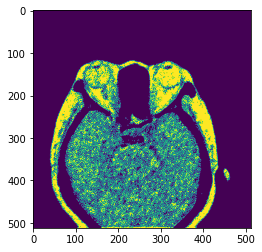

交集： 4265.0   并集: 60699.0
IOU accuracy:  7.026474900739715 % 
----------------------------------------------------------------
epoch: 2   loss:  0.610201895236969


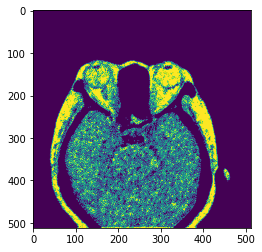

交集： 4122.0   并集: 55652.0
IOU accuracy:  7.406741896068425 % 
----------------------------------------------------------------
epoch: 3   loss:  0.6074399352073669


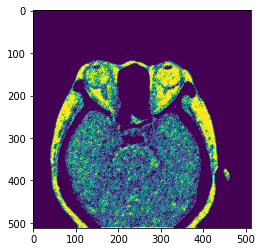

交集： 3920.0   并集: 50238.0
IOU accuracy:  7.802858394044349 % 
----------------------------------------------------------------
epoch: 4   loss:  0.6045657396316528


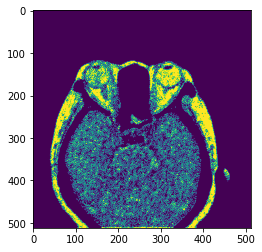

交集： 3714.0   并集: 44702.0
IOU accuracy:  8.308353093821305 % 
----------------------------------------------------------------
epoch: 5   loss:  0.6015909910202026


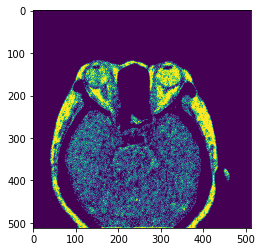

交集： 3435.0   并集: 39202.0
IOU accuracy:  8.762308045507883 % 
----------------------------------------------------------------
epoch: 6   loss:  0.5985250473022461


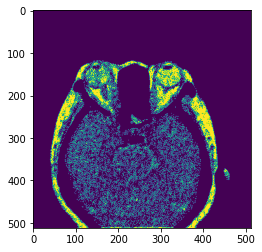

交集： 3139.0   并集: 34012.0
IOU accuracy:  9.229095613312948 % 
----------------------------------------------------------------
epoch: 7   loss:  0.5953775644302368


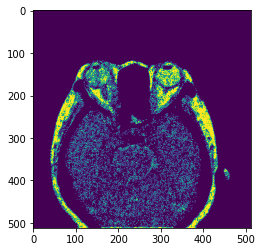

交集： 2826.0   并集: 28966.0
IOU accuracy:  9.756265966995787 % 
----------------------------------------------------------------
epoch: 8   loss:  0.5921590328216553


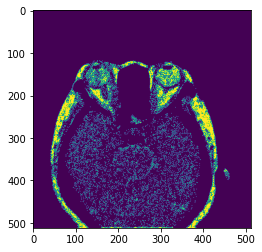

交集： 2462.0   并集: 24673.0
IOU accuracy:  9.978519028897985 % 
----------------------------------------------------------------
epoch: 9   loss:  0.5888785719871521


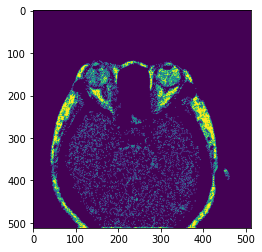

交集： 2081.0   并集: 20959.0
IOU accuracy:  9.928908821985782 % 
----------------------------------------------------------------
epoch: 10   loss:  0.5855410099029541


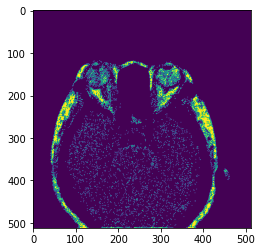

交集： 1683.0   并集: 17901.0
IOU accuracy:  9.401709401709402 % 
----------------------------------------------------------------
epoch: 11   loss:  0.5821468234062195


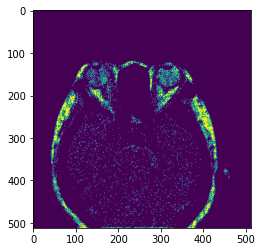

交集： 1301.0   并集: 15534.0
IOU accuracy:  8.375177031028711 % 
----------------------------------------------------------------
epoch: 12   loss:  0.5786936283111572


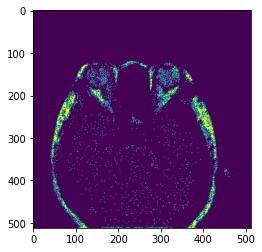

交集： 932.0   并集: 13554.0
IOU accuracy:  6.876198908071418 % 
----------------------------------------------------------------
epoch: 13   loss:  0.5751762390136719


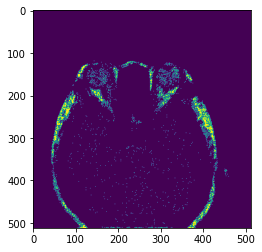

交集： 642.0   并集: 11967.0
IOU accuracy:  5.364753070945099 % 
----------------------------------------------------------------
epoch: 14   loss:  0.5715903639793396


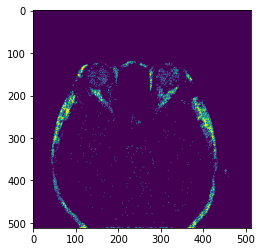

交集： 437.0   并集: 10673.0
IOU accuracy:  4.094443923920172 % 
----------------------------------------------------------------
epoch: 15   loss:  0.5679246783256531


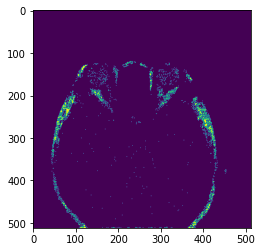

交集： 273.0   并集: 9525.0
IOU accuracy:  2.866141732283465 % 
----------------------------------------------------------------
epoch: 16   loss:  0.5641645193099976


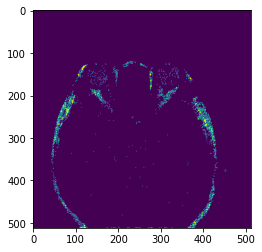

交集： 158.0   并集: 8638.0
IOU accuracy:  1.8291271127575826 % 
----------------------------------------------------------------
epoch: 17   loss:  0.5603089332580566


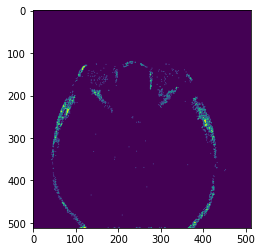

交集： 88.0   并集: 7840.0
IOU accuracy:  1.1224489795918366 % 
----------------------------------------------------------------
epoch: 18   loss:  0.5563703179359436


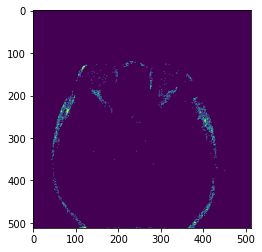

交集： 42.0   并集: 7172.0
IOU accuracy:  0.5856107083100948 % 
----------------------------------------------------------------
epoch: 19   loss:  0.5523571968078613


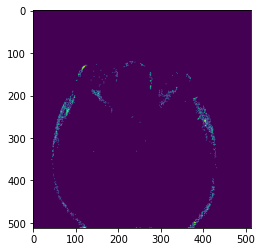

交集： 19.0   并集: 6645.0
IOU accuracy:  0.28592927012791575 % 
----------------------------------------------------------------
epoch: 20   loss:  0.5482734441757202


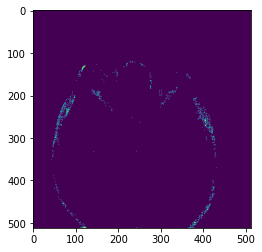

交集： 9.0   并集: 6185.0
IOU accuracy:  0.14551333872271624 % 
----------------------------------------------------------------
epoch: 21   loss:  0.544124186038971


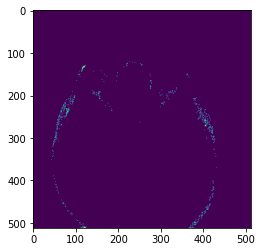

交集： 6.0   并集: 5830.0
IOU accuracy:  0.10291595197255575 % 
----------------------------------------------------------------
epoch: 22   loss:  0.539913535118103


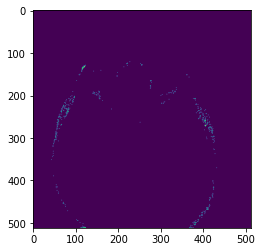

交集： 2.0   并集: 5553.0
IOU accuracy:  0.03601656762110571 % 
----------------------------------------------------------------
epoch: 23   loss:  0.535645604133606


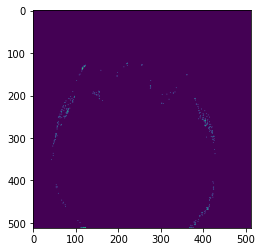

交集： 1.0   并集: 5371.0
IOU accuracy:  0.01861850679575498 % 
----------------------------------------------------------------
epoch: 24   loss:  0.5313238501548767


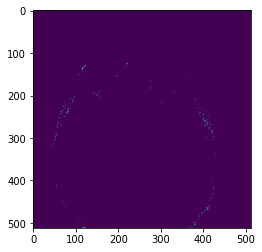

交集： 0.0   并集: 5233.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 25   loss:  0.5269513726234436


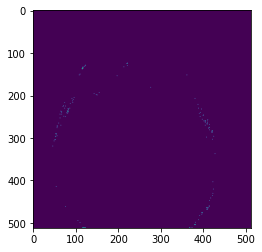

交集： 0.0   并集: 5158.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 26   loss:  0.5225316286087036


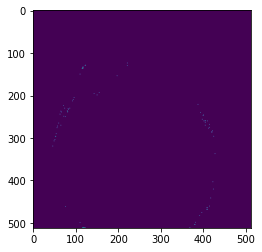

交集： 0.0   并集: 5094.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 27   loss:  0.5180656313896179


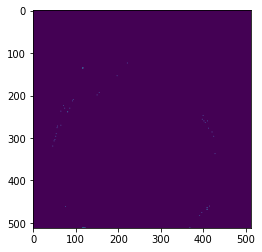

交集： 0.0   并集: 5059.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 28   loss:  0.5135487914085388


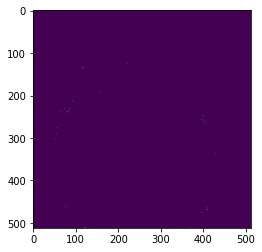

交集： 0.0   并集: 5038.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 29   loss:  0.5089766383171082


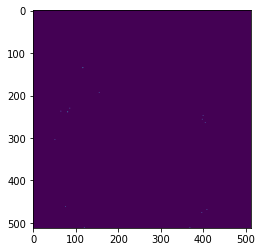

交集： 0.0   并集: 5028.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 30   loss:  0.5043452382087708


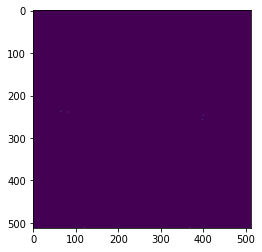

交集： 0.0   并集: 5018.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 31   loss:  0.4996508061885834


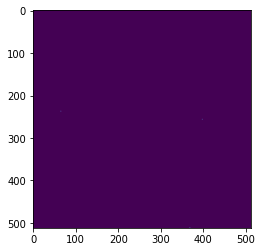

交集： 0.0   并集: 5015.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 32   loss:  0.4948897361755371


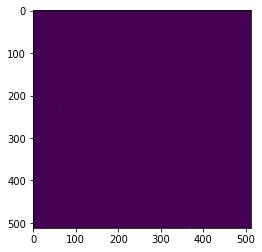

交集： 0.0   并集: 5014.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 33   loss:  0.49005794525146484


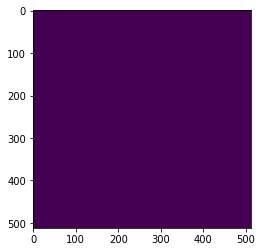

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 34   loss:  0.48515206575393677


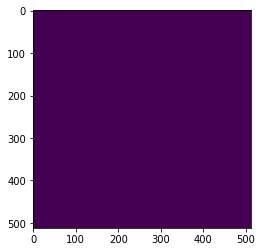

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 35   loss:  0.48017120361328125


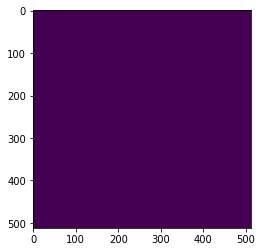

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 36   loss:  0.4751163125038147


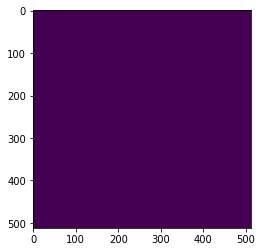

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 37   loss:  0.46999192237854004


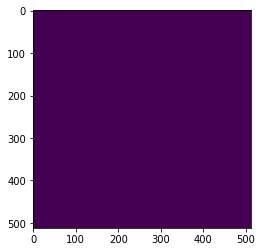

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 38   loss:  0.4648062586784363


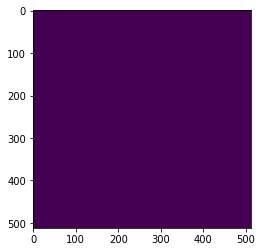

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 39   loss:  0.4595661163330078


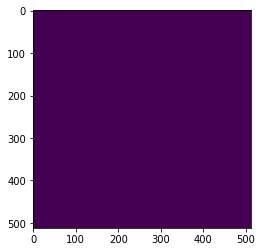

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 40   loss:  0.45427948236465454


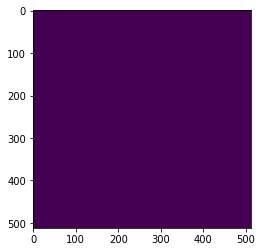

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 41   loss:  0.448953241109848


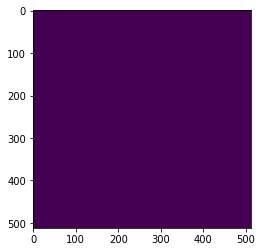

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 42   loss:  0.44359445571899414


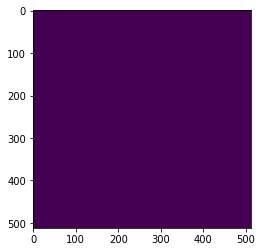

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 43   loss:  0.4382094442844391


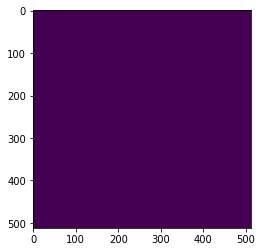

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 44   loss:  0.4328024983406067


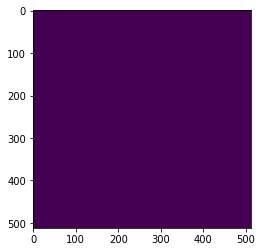

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 45   loss:  0.42737576365470886


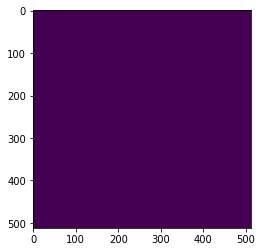

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 46   loss:  0.4219300150871277


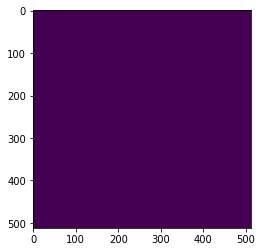

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 47   loss:  0.4164683520793915


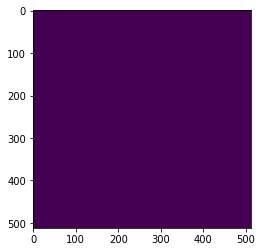

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 48   loss:  0.4109964668750763


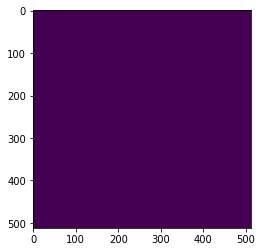

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 49   loss:  0.40552252531051636


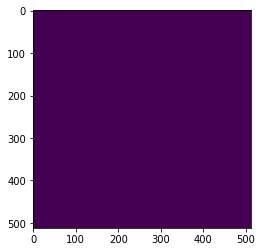

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 50   loss:  0.4000560939311981


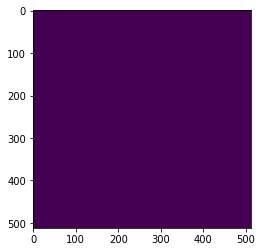

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------


In [ ]:
# torch.cuda.empty_cache()
train()